[View in Colaboratory](https://colab.research.google.com/github/raijinspecial/RECONSTRUST-Acceleration/blob/master/ak.ipynb)

In [0]:
import json
from pprint import pprint
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle
import pandas as pd

In [0]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

In [0]:

def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records

In [0]:
!pip install tensorflow==1.10.0

In [0]:
!pip install keras==2.2.2

In [0]:
!pip install torch==0.4.1

In [0]:
rq = 'requirements.txt'
rid = get_file_id(rq)
move_from_drive_to_disk([rq], ['requirements.txt'])


In [30]:
!ls

adc.json	 requirements.txt  test_label2.csv
drone_test.zip	 sample_data	   train
drone_train.zip  test		   train_label2.csv


In [0]:
!pip install -r requirements.txt

In [0]:
!pip install autokeras

In [0]:
import tensorflow as tf

In [0]:
import autokeras as ak

In [0]:
import cv2
import os
import random
import matplotlib.pylab as plt
from glob import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [0]:
# ../input/
#PATH = os.path.abspath(os.path.join('/content/', 'input'))

# ../input/sample/images/
SOURCE_IMAGES = '/content/input/sample/images'



In [0]:
os.mkdir('/content/input/sample/images')

In [0]:
# ../input/sample/images/*.png
images = glob(os.path.join(SOURCE_IMAGES, "*.jpg"))

# Load labels
labels = pd.read_csv('/content/test_label2.csv')

In [0]:
!unzip drone_train.zip -d ./input/sample/images

In [0]:
move_from_drive_to_disk([trnlab], ['sample_labels.csv'])

In [50]:
# First five images paths
images[0:5]

['/content/input/sample/images/175.jpg',
 '/content/input/sample/images/323.jpg',
 '/content/input/sample/images/6.jpg',
 '/content/input/sample/images/192.jpg',
 '/content/input/sample/images/13.jpg']

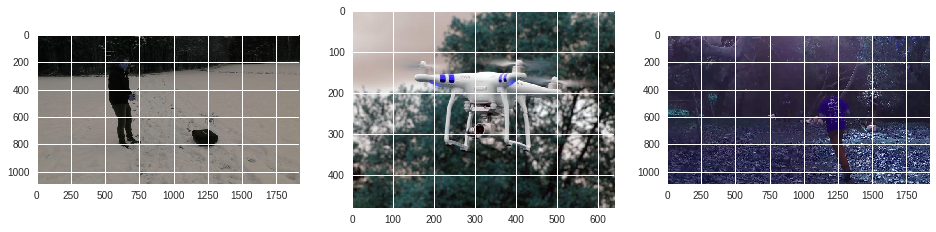

In [51]:
r = random.sample(images, 3)
r

# Matplotlib black magic
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))

plt.subplot(132)
plt.imshow(cv2.imread(r[1]))

plt.subplot(133)
plt.imshow(cv2.imread(r[2])); 

In [0]:
def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    
    disease="Infiltration"

    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
    WIDTH = 128
    HEIGHT = 128

    for img in images:
        base = os.path.basename(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]

        # Read and resize image
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))

        # Labels
        if disease in finding:
            #finding = str(disease)
            finding = 1
            y.append(finding)

        else:
            #finding = "Not_" + str(disease)
            finding = 0
            y.append(finding)

    return x,y

In [53]:
x,y = proc_images()

KeyError: ignored

In [48]:
!ls

adc.json	 input		   test		    train_label2.csv
drone_test.zip	 requirements.txt  test_label2.csv
drone_train.zip  sample_data	   train


In [0]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
example_file_name = 'drone_train.zip'
example_file_id = get_file_id(example_file_name)

In [16]:
move_from_drive_to_disk([example_file_name], ['drone_train.zip'])

Downloaded 86245120/86245120 bytes


In [0]:
example_file_name2 = 'drone_test.zip'
example_file_id2 = get_file_id(example_file_name2)

In [18]:
move_from_drive_to_disk([example_file_name2], ['drone_test.zip'])

Downloaded 33941727/33941727 bytes


In [47]:
tstlab = 'test_label2.csv'
trnlab = 'train_label2.csv'
tstid = get_file_id(tstlab)
trnid = get_file_id(trnlab)

ValueError: ignored

In [0]:
move_from_drive_to_disk([tstlab], ['test_label2.csv'])
move_from_drive_to_disk([trnlab], ['train_label2.csv'])

In [21]:
!ls

adc.json	drone_train.zip  test_label2.csv
drone_test.zip	sample_data	 train_label2.csv


In [0]:
!mkdir train

In [0]:
!mkdir test

In [0]:
!unzip drone_train.zip -d ./train

In [0]:
!unzip drone_test.zip -d ./test

In [0]:
import os

In [0]:
!pip install Pillow==5.0.0
!pip install PIL
!pip install image
#from PIL import Im

In [0]:
!pip show numpy

In [0]:
!pip install --no-cache-dir -I pillow

In [9]:
from autokeras.image_supervised import load_image_dataset

x_train, y_train = load_image_dataset(csv_file_path='train_label2.csv',
                                      images_path='/content/train')
print(x_train.shape)
print(y_train.shape)

(350,)
(350,)


In [0]:
x_test, y_test = load_image_dataset(csv_file_path='test_label2.csv',
                                    images_path='/content/test')
print(x_test.shape)
print(y_test.shape)

In [0]:
from autokeras.image_supervised import ImageClassifier

In [0]:
clf = ImageClassifier(verbose=True)
clf.fit(x_train, y_train, time_limit=12 * 60 * 60)
clf.final_fit(x_train, y_train, x_test, y_test, retrain=True)
y = clf.evaluate(x_test, y_test)
print(y)

In [72]:
x_train.dtype

dtype('O')

In [0]:
x_trains = x_train.reshape(x_train.shape + (-1,1))

In [0]:
x_trains = x_train.reshape(-1,1)

In [0]:
x_train.ravel().ravel()

In [0]:
rr=pd.Series(x_train)

In [0]:
import pandas as pd

In [0]:
ww=list()
for x in x_train:
  ww.append(x)

In [88]:
len(ww)

350

In [0]:
ww

In [0]:
rr

In [0]:
ari=list()
ri=list()
eli=list()
#for arr_i, arr in enumerate(rr):
    #ari.append(arr_i)

    for row_i, row in enumerate(arr):
        ri.append(row_i)

        for el in row:
            eli.append(el)

In [17]:
len(ri)

368217

In [15]:
len(ari)

350

In [25]:
len(el)

3

In [0]:
for row_i, row in enumerate(arr):
    ri.append(row_i)

    for el in row:
        eli.append(el)

In [68]:
from keras.datasets import mnist
from autokeras.image_supervised import ImageClassifier

if __name__ == '__main__':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.reshape(x_test.shape + (1,))

11493376/11490434 [==============================] - 1s 0us/step


In [69]:
x_train.shape

(60000, 28, 28, 1)